# Creating and Re-Training Models

Roboflow provides you with tools to create your computer vision (CV) models.

Creating robust CV models is centered around gathering a representative dataset and iterating on that dataset as your model needs to improve.

In this notebook, we're going to start with a blood cell dataset that has been overfit to run inference on images from a particular microscope. We'll add more data to the dataset to improve the model's ability to generalize and identify blood cells on different tasks.

Let's walk through an example of retraining a computer vision model on Roboflow to fix a prediction error.

In [4]:
import roboflow
roboflow.login()

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).


First, let's load our model and run inference on an example image. All of the dataset images come from the same microscope view visualized below.

loading Roboflow workspace...
loading Roboflow project...


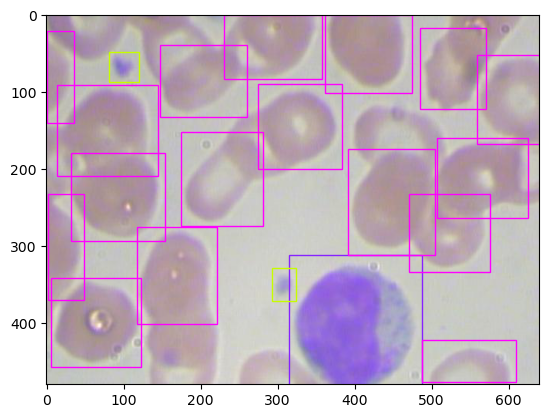

In [2]:
img_url = "https://media.roboflow.com/quickstart/blood_cells1.jpeg?updatedAt=1678743538023"
universe_url = "https://universe.roboflow.com/joshua-kenan-cinches/bccd-yolov5-ntmab/model/1"

model = roboflow.load_model(model_url=universe_url)
pred = model.predict(img_url, hosted=True, confidence=10)
pred.plot()

If we try the model on an image from a different microscope, our model returns poor results:

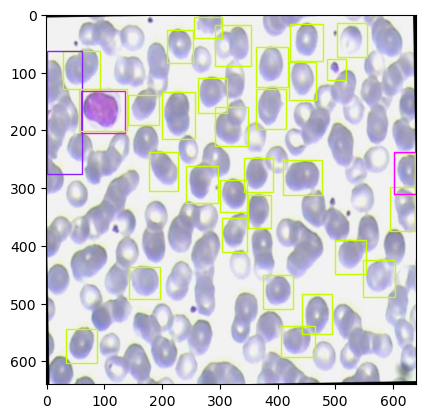

In [3]:
img_url = "https://media.roboflow.com/quickstart/blood_cells2.jpeg?updatedAt=1678743546000"
pred = model.predict(img_url, hosted=True, confidence=50)
pred.plot()

## Active Learning: Fixing Model Predictions by Re-Training our Model

Now that we have identified an issue with our model, we need to get to work to fix it! We can do so by adding more data to our dataset from a different source (in this case, a new microscope). By adding data from a new source, we can help our model learn how to identify patterns that are not specific to a particular set of images (or, in this example, a specific microscope). After we add new images, we'll train a new version of our model.

Here are the steps we'll follow:

* Create a new project in Roboflow
* Download and upload the original model's dataset to the project
* Upload labeled data from the new microsope angle to the new proejct
* Generate a new dataset version and retrain it

In [4]:
#create new roboflow project
from roboflow import Roboflow
workspace = Roboflow().workspace()
new_project = workspace.create_project(project_name="blood-cells-retraining6",project_license="MIT",project_type="object-detection", annotation="cells1023")


loading Roboflow workspace...
loading Roboflow project...


In [5]:
#download old dataset images
rf = Roboflow()
old_microscope_project = rf.workspace("joshua-kenan-cinches").project("bccd-yolov5-ntmab")
old_microscope_dataset = old_microscope_project.version(2).download("voc")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to bccd-yolov5-2 in voc:: 100%|█| 733/733 [00:00<


In [12]:
#add new images
#here we will add pre labeled images - in most cases you will need to annotate new images to 
new_microscope_project = rf.workspace("roboflow-gw7yv").project("blood-cell-new-microscope")
new_microscope_dataset = new_microscope_project.version(2).download("voc")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Blood-Cell-New-Microscope-2 in voc:: 100%|█| 1


In [8]:
import glob
import random
from tqdm import tqdm

#upload old microscope training images
pbar = tqdm(glob.glob(old_microscope_dataset.location + "/train/*.jpg"))
for img_file in pbar:
    label_file = img_file.replace(".jpg", ".xml")
    new_project.upload(image_path=img_file, annotation_path=label_file, split="train")

#upload old microscope validation images
for img_file in tqdm(glob.glob(old_microscope_dataset.location + "/valid/*.jpg")):
    label_file = img_file.replace(".jpg", ".xml")
    new_project.upload(image_path=img_file, annotation_path=label_file, split="valid")
    
#upload old microscope test images
for img_file in tqdm(glob.glob(old_microscope_dataset.location + "/test/*.jpg")):
    label_file = img_file.replace(".jpg", ".xml")
    new_project.upload(image_path=img_file, annotation_path=label_file, split="test")

#upload new microscope to new splits with probability 70,20,10
for img_file in tqdm(glob.glob(new_microscope_dataset.location + "/train/*.jpg")):
    label_file = img_file.replace(".jpg", ".xml")
    split = random.choice(["train"]*7 + ["valid"]*2 + ["test"]*1)
    new_project.upload(image_path=img_file, annotation_path=label_file, split="train")

100%|█████████████████████████████████████████| 255/255 [05:44<00:00,  1.35s/it]


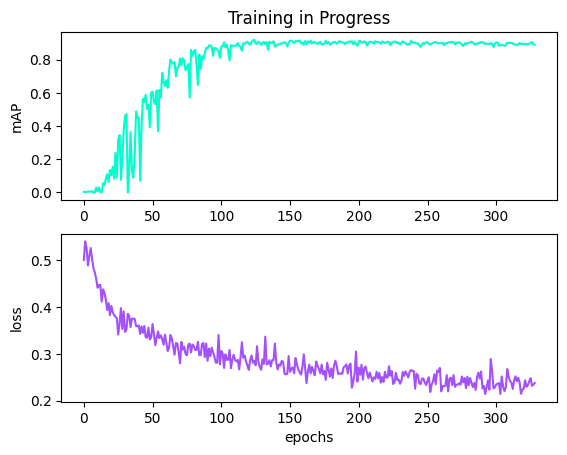

In [9]:
new_model = new_project.train(plot_in_notebook=True)

Want a sneak peek at the results while waiting for the training to complete? You can try our pre-made improved model by running the code cell below.

In [10]:
import roboflow
from urllib.parse import urlparse
universe_model_url = "https://universe.roboflow.com/jacob-solawetz/blood-cells-combined-xujui/model/1"
new_model = roboflow.load_model(model_url=universe_model_url)

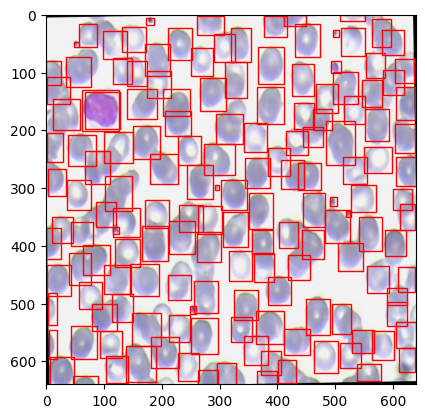

In [15]:
img_url = "https://media.roboflow.com/quickstart/blood_cells2.jpeg?updatedAt=1678743546000"
pred = new_model.predict(img_url, hosted=True, confidence=60)
pred.plot()

In [13]:
pred.json()

{'predictions': [{'x': 140.5,
   'y': 412.5,
   'width': 43.0,
   'height': 49.0,
   'confidence': 0.9125190377235413,
   'class': 'RBC',
   'image_path': 'https://storage.googleapis.com/roboflow-platform-sources/Un6Oj918VoacT7AE2ql63T5q4ft1/85ljLudEpEbiURKj8MQO/original.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 388.5,
   'y': 87.5,
   'width': 45.0,
   'height': 63.0,
   'confidence': 0.9033741354942322,
   'class': 'RBC',
   'image_path': 'https://storage.googleapis.com/roboflow-platform-sources/Un6Oj918VoacT7AE2ql63T5q4ft1/85ljLudEpEbiURKj8MQO/original.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 402.0,
   'y': 254.5,
   'width': 38.0,
   'height': 49.0,
   'confidence': 0.9025548696517944,
   'class': 'RBC',
   'image_path': 'https://storage.googleapis.com/roboflow-platform-sources/Un6Oj918VoacT7AE2ql63T5q4ft1/85ljLudEpEbiURKj8MQO/original.jpg',
   'prediction_type': 'ObjectDetectionModel'},
  {'x': 387.0,
   'y': 540.5,
   'width': 48.0,
   'heig

Through training and retraining procedures, you can quickly iterate on your computer visions datasets and models with Roboflow.

## Bonus: Build Your Own Model from Scratch

Eager to jump in and start building your own model? We've got you covered. If you already have an idea for a model you want to build, you can bring it to reality with Roboflow. In the video below, we walk through how to build a model from scratch with Roboflow. If you'd like to move on to learning about different model types, feel free to skip this section and come back when you are ready!

In [3]:
from IPython.display import Video

Video("https://media.roboflow.com/homepage/video/build-a-coin-counter-app-w-roboflow-resize.mp4", width=900, height=576)

## Next Up: Roboflow Model Types

Next, we will look into the differnt types of computer vision tasks you can accomplish with Roboflow. 

* Object detection
* Classification
* Instance segmentation

Run the code cell below to move on to the next tutorial.

In [2]:
from notebook import notebookapp
import webbrowser
jupyter_server = list(notebookapp.list_running_servers())[0]["url"]
webbrowser.open(jupyter_server + "notebooks/model-types.ipynb")

True